In [17]:
# Data processing

import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Model and performance
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from glob import glob


In [18]:
from pre import Training_data

training_data = Training_data('training',11)

data: training_data.npy| labels: training_labels.npy


In [19]:
ano = training_data.get_ano()

In [20]:
_dices = training_data.dices

In [26]:
labels = training_data.labels

In [21]:
raw = training_data.get_raw()

In [25]:
for i in raw:
    print(i.shape)

(737, 128, 128, 1)
(540, 128, 128, 1)
(484, 128, 128, 1)
(606, 128, 128, 1)
(624, 128, 128, 1)
(932, 128, 128, 1)
(906, 128, 128, 1)
(413, 128, 128, 1)
(398, 128, 128, 1)
(511, 128, 128, 1)
(420, 128, 128, 1)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(_dices,labels,test_size=0.2,random_state=42)


In [34]:
X_train.shape

(5256, 128, 128, 1)

In [44]:
#parameters
input_size = 128
filter = 64


strides = (2, 2)
pool_size = (2,2)
kernel_size = (3,3)

In [49]:
with tf.device('/GPU:0'):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    

    input = keras.Input(shape=(128,128,1), name='img')
    #c1
    encoded = keras.layers.Conv2D(32,kernel_size=kernel_size,strides=1,padding='same',name='c1')(input)
    encoded = keras.layers.MaxPooling2D(pool_size=pool_size,strides=strides,padding='same')(encoded)
    encoded = keras.layers.BatchNormalization(name='bn1')(encoded)
    encoded = keras.layers.LeakyReLU(name='LR1')(encoded)

    #c2
    encoded = keras.layers.Conv2D(16,kernel_size=kernel_size,strides=2,padding='same',name='c2')(encoded)
    encoded = keras.layers.MaxPooling2D(pool_size=pool_size,strides=strides,padding='same')(encoded)
    encoded = keras.layers.BatchNormalization(name='bn2')(encoded)
    encoded = keras.layers.LeakyReLU(name='LR2')(encoded)

    #c3
    encoded = keras.layers.Conv2D(8,kernel_size=kernel_size,strides=2,padding='same',name='c3')(encoded)
    encoded = keras.layers.MaxPooling2D(pool_size=pool_size,strides=strides,padding='same')(encoded)
    encoded = keras.layers.BatchNormalization(name='bn3')(encoded)
    encoded = keras.layers.LeakyReLU(name='LR3')(encoded)



    dencoded = keras.layers.Conv2DTranspose(8,kernel_size=kernel_size,strides=2,padding='same',name='ct1')(encoded)
    dencoded = keras.layers.UpSampling2D(pool_size)(dencoded)
    dencoded = keras.layers.BatchNormalization(name='bn4')(dencoded)
    dencoded= keras.layers.LeakyReLU(name='LR4')(dencoded)

    #c2
    dencoded= keras.layers.Conv2DTranspose(16,kernel_size=kernel_size,strides=2,padding='same',name='ct2')(dencoded)
    dencoded = keras.layers.UpSampling2D(pool_size)(dencoded)
    dencoded= keras.layers.BatchNormalization(name='bn5')(dencoded)
    dencoded= keras.layers.LeakyReLU(name='LR5')(dencoded)

    #c3
    dencoded= keras.layers.Conv2DTranspose(32,kernel_size=kernel_size,strides=1,padding='same',name='ct3')(dencoded)
    dencoded = keras.layers.UpSampling2D(pool_size)(dencoded)
    dencoded= keras.layers.BatchNormalization(name='bn6')(dencoded)
    dencoded= keras.layers.LeakyReLU(name='LR6')(dencoded)

    output = keras.layers.Conv2DTranspose(1,3,1,padding='same',activation='sigmoid',name='ct4')(dencoded)
    autoencoder = tf.keras.Model(input,output)
    autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 1)]     0         
                                                                 
 c1 (Conv2D)                 (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 bn1 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 LR1 (LeakyReLU)             (None, 64, 64, 32)        0         
                                                                 
 c2 (Conv2D)                 (None, 32, 32, 16)        4624      
                                                           

In [51]:
def SSIMLoss(y_true,y_pred):
    return 1-tf.reduce_mean(tf.image.ssim(y_true,y_pred,1.0))

In [52]:
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

In [53]:
from keras.callbacks import TensorBoard

In [54]:
with tf.device('/GPU:0'):
    autoencoder.fit(
    x=X_train,
    y=X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test,X_test),
    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]

    
)

Epoch 1/20
42/42 [==============================] - 53s 936ms/step - loss: 0.6092 - val_loss: 0.4529
Epoch 2/20
42/42 [==============================] - 25s 602ms/step - loss: 0.3913 - val_loss: 0.4367
Epoch 3/20
42/42 [==============================] - 27s 639ms/step - loss: 0.3285 - val_loss: 0.4378
Epoch 4/20
42/42 [==============================] - 35s 845ms/step - loss: 0.2967 - val_loss: 0.4364
Epoch 5/20
42/42 [==============================] - 36s 859ms/step - loss: 0.2732 - val_loss: 0.4310
Epoch 6/20
42/42 [==============================] - 39s 933ms/step - loss: 0.2560 - val_loss: 0.4275
Epoch 7/20
42/42 [==============================] - 39s 930ms/step - loss: 0.2433 - val_loss: 0.4263
Epoch 8/20
42/42 [==============================] - 39s 920ms/step - loss: 0.2342 - val_loss: 0.4225
Epoch 9/20
42/42 [==============================] - 39s 923ms/step - loss: 0.2283 - val_loss: 0.4126
Epoch 10/20
42/42 [==============================] - 40s 945ms/step - loss: 0.2228 - val_lo

In [55]:
test_data = Training_data('test',11)

data: test_data.npy| labels: test_labels.npy


In [56]:
test = test_data.dices

In [60]:
test1 = test[:1]
test1.shape

(1, 128, 128, 1)

In [64]:
test_ano = test_data.get_ano()

In [66]:
test_ano1 = test_ano[:1]

In [61]:
predict1 = autoencoder.predict(test1)

In [67]:
predict_ano = autoencoder.predict(test_ano1)

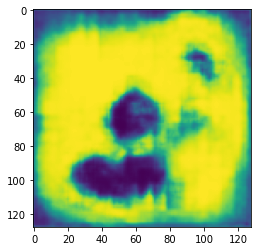

In [68]:
plt.imshow(predict_ano[0])

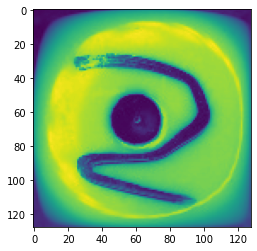

In [69]:
plt.imshow(test_ano1[0])

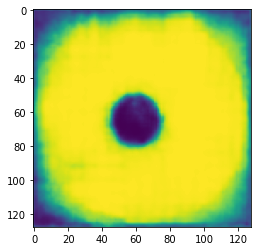

In [62]:
plt.imshow(predict1[0])

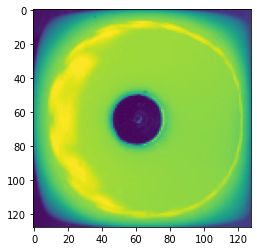

In [63]:

plt.imshow(test1[0])

In [70]:
ab = Training_data('training',0)

the classes options are 6 or 11
something wrong, see if all arguments are filled!
